<a href="https://colab.research.google.com/github/Pranav-Tanwar/OJ_Project/blob/main/Copy_of_OC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile kernels.h
#ifndef KERNELS_H_
#define KERNELS_H_

#include <vector>

struct Image {
    int width;
    int height;
    std::vector<unsigned char> pixels;
};

void LaunchGrayscaleKernel(const Image& input_image, Image* output_image);

#endif

Writing kernels.h


In [ ]:
%%writefile kernels.cu
#include "kernels.h"
#include <cuda_runtime.h>
#include <iostream>
#include <cstdio>

// Error checking macro
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true) {
   if (code != cudaSuccess) {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void GrayscaleKernel(unsigned char* d_in, unsigned char* d_out, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int idx = (y * width + x) * 3;

        unsigned char r = d_in[idx];
        unsigned char g = d_in[idx + 1];
        unsigned char b = d_in[idx + 2];

        // Luminosity formula
        unsigned char gray = (unsigned char)(0.21f * r + 0.71f * g + 0.07f * b);

        d_out[idx]     = gray;
        d_out[idx + 1] = gray;
        d_out[idx + 2] = gray;
    }
}

void LaunchGrayscaleKernel(const Image& input_image, Image* output_image) {
    int width = input_image.width;
    int height = input_image.height;
    size_t image_size = width * height * 3 * sizeof(unsigned char);

    unsigned char *d_in, *d_out;

    // Allocate and Check
    gpuErrchk(cudaMalloc((void**)&d_in, image_size));
    gpuErrchk(cudaMalloc((void**)&d_out, image_size));

    // Copy and Check
    gpuErrchk(cudaMemcpy(d_in, input_image.pixels.data(), image_size, cudaMemcpyHostToDevice));

    dim3 block_dim(16, 16);
    dim3 grid_dim((width + block_dim.x - 1) / block_dim.x,
                  (height + block_dim.y - 1) / block_dim.y);

    // Launch
    GrayscaleKernel<<<grid_dim, block_dim>>>(d_in, d_out, width, height);

    // Check for Launch Errors
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());

    // Copy Back
    output_image->width = width;
    output_image->height = height;
    output_image->pixels.resize(input_image.pixels.size());
    gpuErrchk(cudaMemcpy(output_image->pixels.data(), d_out, image_size, cudaMemcpyDeviceToHost));

    cudaFree(d_in);
    cudaFree(d_out);
}

Overwriting kernels.cu


In [ ]:
%%writefile main.cpp
#include <iostream>
#include <string>
#include <vector>
#include <filesystem>
#include <fstream>
#include <chrono>
#include "kernels.h"

namespace fs = std::filesystem;

bool ReadPpm(const std::string& filename, Image& img) {
    std::ifstream file(filename);
    if (!file.is_open()) return false;
    std::string format;
    int max_val;
    file >> format >> img.width >> img.height >> max_val;
    if (format != "P3") return false;
    img.pixels.resize(img.width * img.height * 3);
    for (size_t i = 0; i < img.pixels.size(); ++i) {
        int pixel_val;
        file >> pixel_val;
        img.pixels[i] = static_cast<unsigned char>(pixel_val);
    }
    return true;
}

void WritePpm(const std::string& filename, const Image& img) {
    std::ofstream file(filename);
    file << "P3\n" << img.width << " " << img.height << "\n255\n";
    for (size_t i = 0; i < img.pixels.size(); ++i) {
        file << (int)img.pixels[i] << (i % 3 == 2 ? "\n" : " ");
    }
}

int main(int argc, char* argv[]) {
    if (argc < 3) {
        std::cout << "Usage: ./img_proc <input_dir> <output_dir>" << std::endl;
        return 1;
    }
    std::string input_dir = argv[1];
    std::string output_dir = argv[2];

    // Ensure output directory exists
    if (!fs::exists(output_dir)) fs::create_directory(output_dir);

    std::cout << "Processing images from " << input_dir << " to " << output_dir << "..." << std::endl;
    int file_count = 0;
    auto start_total = std::chrono::high_resolution_clock::now();

    for (const auto& entry : fs::directory_iterator(input_dir)) {
        std::string path = entry.path().string();
        if (path.substr(path.find_last_of(".") + 1) == "ppm") {
            std::cout << "Processing: " << entry.path().filename() << "... ";
            Image input_img, output_img;
            if (ReadPpm(path, input_img)) {
                LaunchGrayscaleKernel(input_img, &output_img);
                std::string out_path = output_dir + "/" + entry.path().filename().string();
                WritePpm(out_path, output_img);
                std::cout << "Done." << std::endl;
                file_count++;
            }
        }
    }
    auto end_total = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end_total - start_total;
    std::cout << "Processed " << file_count << " images in " << elapsed.count() << " seconds." << std::endl;
    return 0;
}

Writing main.cpp


In [ ]:
%%writefile Makefile
SHELL := /bin/bash
NVCC = nvcc
# Using C++17 and generic architecture flag
NVCC_FLAGS = -std=c++17 -Wno-deprecated-gpu-targets

TARGET = img_proc
SRCS = main.cpp kernels.cu
DATA_IN = data/input
DATA_OUT = data/output

all: $(TARGET)

$(TARGET): $(SRCS)
	$(NVCC) $(NVCC_FLAGS) -o $(TARGET) $(SRCS)

run: $(TARGET)
	@mkdir -p $(DATA_IN)
	@mkdir -p $(DATA_OUT)
	@if [ -z "$$(ls -A $(DATA_IN))" ]; then \
		echo "Creating dummy test_image.ppm..."; \
		echo "P3 100 100 255" > $(DATA_IN)/test_image.ppm; \
		for i in {1..10000}; do echo "255 0 0 "; done >> $(DATA_IN)/test_image.ppm; \
	fi
	./$(TARGET) ./$(DATA_IN) ./$(DATA_OUT)

clean:
	rm -f $(TARGET) *.o

Writing Makefile


In [ ]:
!make run

nvcc -std=c++17 -Wno-deprecated-gpu-targets -o img_proc main.cpp kernels.cu
Creating dummy test_image.ppm...
./img_proc ./data/input ./data/output
Processing images from ./data/input to ./data/output...
Processing: "test_image.ppm"... Done.
Processed 1 images in 0.19426 seconds.


In [ ]:
%%writefile Makefile
SHELL := /bin/bash
NVCC = nvcc
# Use native architecture to avoid "sm_60" errors on newer Colab GPUs
NVCC_FLAGS = -std=c++17 -arch=native

TARGET = img_proc
SRCS = main.cpp kernels.cu
DATA_IN = data/input
DATA_OUT = data/output

all: $(TARGET)

$(TARGET): $(SRCS)
	$(NVCC) $(NVCC_FLAGS) -o $(TARGET) $(SRCS)

run: $(TARGET)
	@mkdir -p $(DATA_IN)
	@mkdir -p $(DATA_OUT)
	@echo "Generating Colorful Test Image..."
	@# Generate a Rainbow Gradient (Red=x, Green=y, Blue=0)
	@# This creates a square that fades from Black -> Red -> Yellow -> Green
	@python3 -c "print('P3 256 256 255'); [print(f'{x} {y} 0') for y in range(256) for x in range(256)]" > $(DATA_IN)/test_image.ppm

	@echo "Running CUDA Processor..."
	./$(TARGET) ./$(DATA_IN) ./$(DATA_OUT)

clean:
	rm -f $(TARGET) *.o
	rm -rf $(DATA_IN) $(DATA_OUT)

Overwriting Makefile


In [ ]:
!make clean && make run

rm -f img_proc *.o
rm -rf data/input data/output
nvcc -std=c++17 -arch=native -o img_proc main.cpp kernels.cu
Generating Colorful Test Image...
Running CUDA Processor...
./img_proc ./data/input ./data/output
Processing images from ./data/input to ./data/output...
Processing: "test_image.ppm"... Done.
Processed 1 images in 0.128994 seconds.


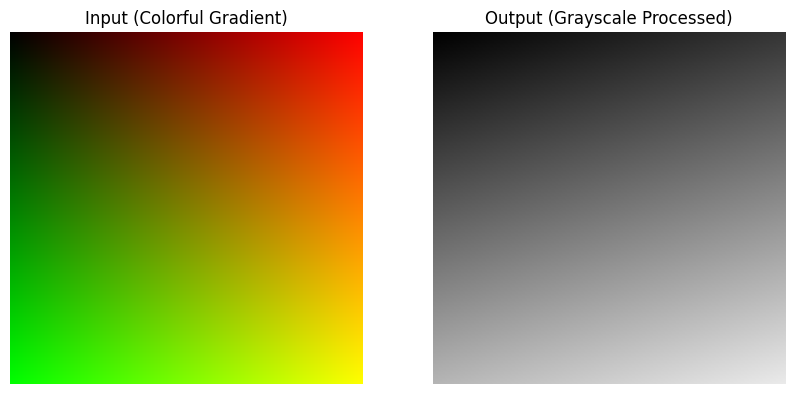

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Paths
input_path = 'data/input/test_image.ppm'
output_path = 'data/output/test_image.ppm'

if os.path.exists(input_path) and os.path.exists(output_path):
    # Load Images
    img_in = Image.open(input_path)
    img_out = Image.open(output_path)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_in)
    axes[0].set_title("Input (Colorful Gradient)")
    axes[0].axis('off')

    axes[1].imshow(img_out, cmap='gray')
    axes[1].set_title("Output (Grayscale Processed)")
    axes[1].axis('off')

    plt.show()
else:
    print("Images not found. Did the Make command run successfully?")